In [1]:
import os
import sys
import numpy as np
import sympy as sp
import torch as pt
from torch.nn.functional import normalize
import scipy
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import logging
import sys
from torch.utils.data import TensorDataset, DataLoader
from torch.func import hessian, vmap
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")

sys.path.append(os.path.abspath('../../'))

from src.useful_functions import *
from src.data_modules.PWDs_module import generate_PWDistances_torch
from src.data_modules.sqra_functions import*
from src.data_modules.openmm_functions import*
from src.isokann.isokann_modules import*
# For reproducibility
np.random.seed(0)


# Read directory paths
read_dirs_paths('../dir_paths.txt', globals())



 
Created variables:
inp_dir = /scratch/htc/fsafarov/2cm2_simulation/md2/input/
dcd_dir = /scratch/htc/fsafarov/2cm2_simulation/md2/output/trajectories/openmm_files
out_dir = /scratch/htc/fsafarov/ISOKANN_PINN/output/


In [2]:
# chi, L_chi = generator_action(base_mlp, x, forces, D)

In [3]:
# pdb_file = 'pdbfile_water.pdb'
# smiles = 'Cc1ccc2c(c1)c(cc(n2)C(F)(F)F)N3CCNCC3'


# system = setup_system(
#                     base=inp_dir,
#                     smiles=smiles, 
#                     nbcutoff = 1.0,
#                     from_pdb=True,
#                     pdb_file=pdb_file, 
#                 )


# dcd_file = 'trajectory_water_combined6.dcd'
# dt=2.0
# gamma=1.0
# T=310.15
# platform='CUDA'


# forces = get_parameters(
#                         system,
#                         inp_dir,
#                         dcd_file,
#                         dcd_dir,
#                         dt, #in femtoseconds
#                         T,
#                         gamma,
#                         platform,
#                         pdb_file=pdb_file,
#                         integrator_type='Langevin',
#                         get_potential_grad=True
#                       )



In [4]:
# import mdtraj as md 

# top = md.load(os.path.join(inp_dir, pdb_file)).topology
# ca_indices = top.select("name CA")

# lig_indices = top.select("resname KB8 and not element H")

# sel_idx = np.unique(np.concatenate([ca_indices, lig_indices]))

In [5]:
# # forces_ = np.linalg.norm(forces, axis=-1)

# forces_ = forces[:, sel_idx]



In [6]:
# coords = get_parameters(
#                         system,
#                         inp_dir,
#                         dcd_file,
#                         dcd_dir,
#                         dt, #in femtoseconds
#                         T,
#                         gamma,
#                         platform,
#                         pdb_file=pdb_file,
#                         integrator_type='Langevin',
#                         get_coords=True
#                       )

In [7]:
# # positions = np.linalg.norm(coords, axis=-1)
# coords_ = coords[:, sel_idx]

In [8]:
# forces_ = pt.Tensor(forces_)
# coords_ = pt.Tensor(coords_)

In [9]:
# pt.save(forces_, os.path.join(out_dir, '8g65_force_components.pt'))
# pt.save(coords_, os.path.join(out_dir, '8g65_coords.pt'))

In [10]:
forces = pt.load(os.path.join(out_dir, '8g65_force_components.pt'))
positions = pt.load(os.path.join(out_dir, '8g65_coords.pt'))
positions = positions.reshape(positions.shape[0], -1 )
forces = forces.reshape(forces.shape[0], -1 )

In [11]:
inp_dim = positions.shape[-1]
nodes = [inp_dim, 256, 128, 64, 1] 
base_mlp = MLP(nodes, act_fun='gelu')

In [12]:
model = ratesNN(base_mlp)
# optimizer = pt.optim.Adam(base_mlp.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer = pt.optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-5, momentum=0.85, nesterov=True)
# D=2.5

trained_model = trainNN(
    model=model, 
    coords=positions.to(device), 
    forces_fn=forces.to(device), 
    batch_size=500,
    optimizer=optimizer, 
    Nepochs=1000,
    lam_bound=10,
    device=device
)

epoch   0 | loss 0.010290 |
epoch 125 | loss 0.002184 |
epoch 250 | loss 0.001241 |
epoch 375 | loss 0.000869 |
epoch 500 | loss 0.000667 |
epoch 625 | loss 0.000541 |
epoch 750 | loss 0.000454 |
epoch 875 | loss 0.000391 |
epoch 1000 | loss 0.000343 |


In [13]:
with pt.no_grad():
    chi = model(positions.to(device))


In [14]:
def scale_and_shift(y):
    minarr = pt.min(y)
    maxarr = pt.max(y)
    hat_y =  (y - minarr) / (maxarr - minarr)

    return hat_y

chi_s = scale_and_shift(chi)

In [15]:
chi_s = chi_s.squeeze(-1).cpu().detach().numpy()



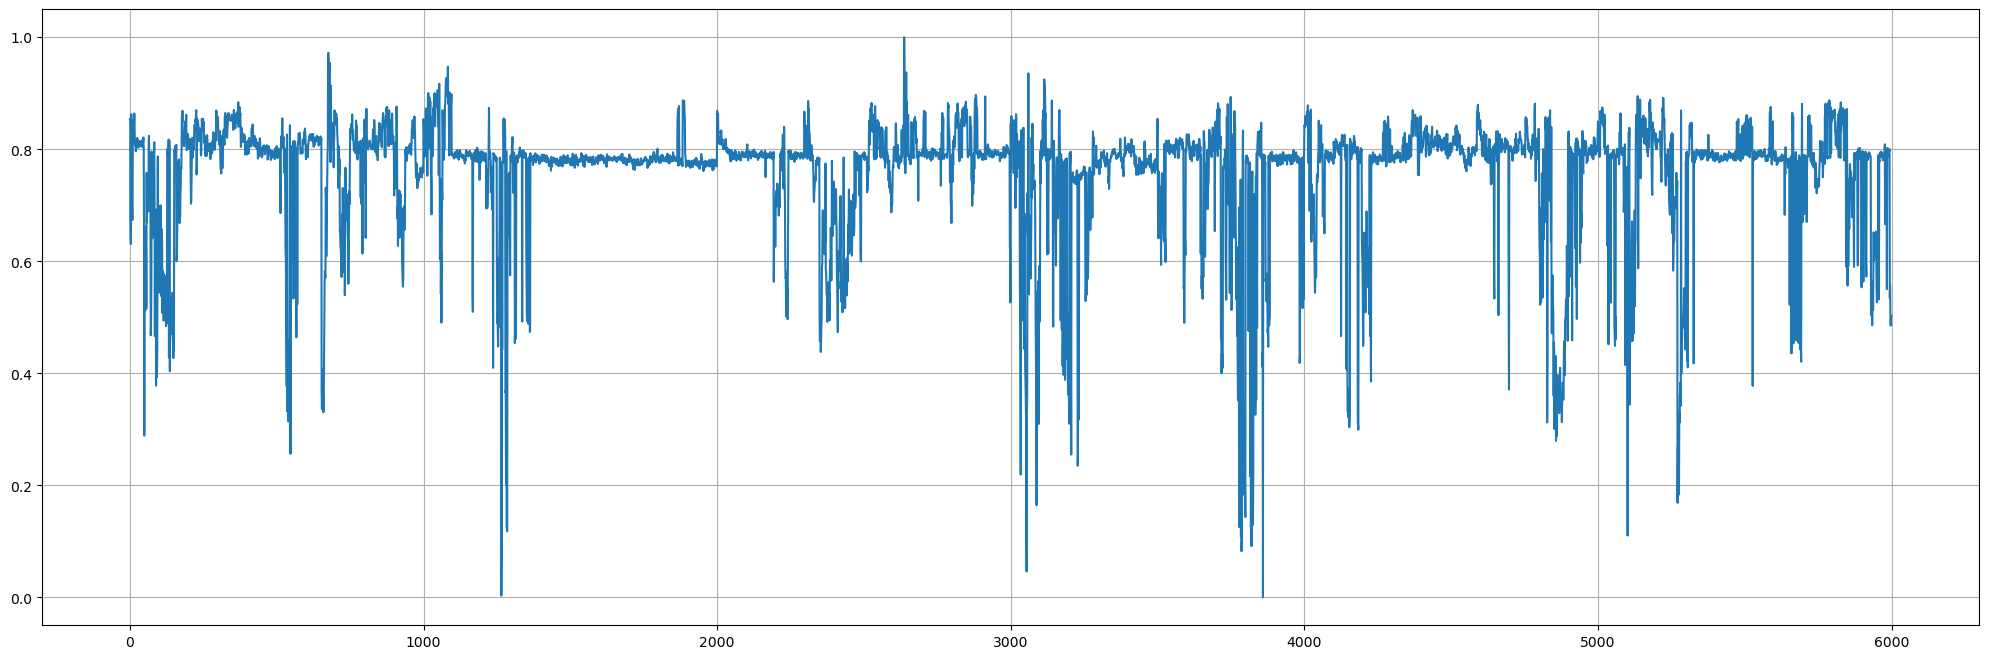

In [16]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(25,8))
plt.plot(chi_s)
plt.grid()

In [17]:
del forces_ 
del forces
del positions
del coords

NameError: name 'forces_' is not defined

In [ ]:
np.savetxt(os.path.join(out_dir, 'chi_0.txt'), chi_s)

In [ ]:
chi0 = np.loadtxt('/scratch/htc/fsafarov/2cm2_simulation/md2/output/isokann/outs_26/' + 'chi0_lr.txt')
chi_m = np.array([chi0, chi_s])

In [ ]:
from scipy.linalg import svd
U, S, V = svd(chi_m)

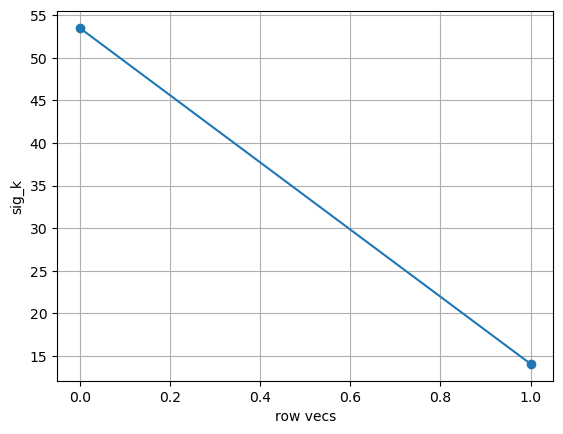

In [ ]:
plt.plot(S, 'o-')
plt.xlabel('row vecs')
plt.ylabel('sig_k')
plt.grid()

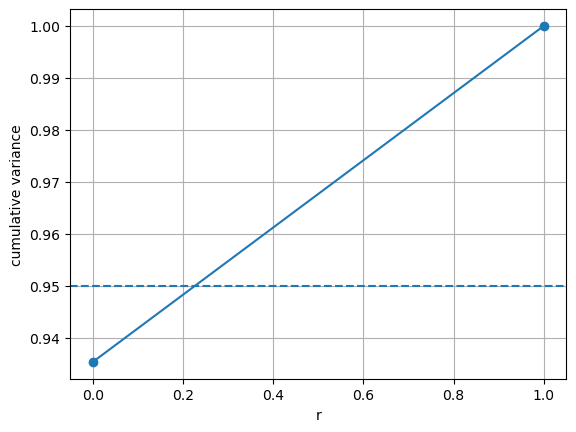

In [ ]:
varfrac = (S**2)/np.sum(S**2)
plt.plot(np.cumsum(varfrac), 'o-'); plt.axhline(0.95, ls='--');
plt.xlabel('r')
plt.ylabel('cumulative variance')
plt.grid()

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(c2_vals)
plt.grid()

NameError: name 'plt' is not defined